<h1>11장 분류용 표현 모델 미세 튜닝하기</h1>
<i>표현 모델의 분류 성능 탐험하기</i>

<a href="https://github.com/rickiepark/handson-llm"><img src="https://img.shields.io/badge/GitHub%20Repository-black?logo=github"></a>
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rickiepark/handson-llm/blob/main/chapter11.ipynb)

---

이 노트북은 <[핸즈온 LLM](https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961)> 책 11장의 코드를 담고 있습니다.

---

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961">
<img src="https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/images/book_cover.png" width="350"/></a>

### [선택사항] - <img src="https://colab.google/static/images/icons/colab.png" width=100>에서 패키지 선택하기


이 노트북을 구글 코랩에서 실행한다면 다음 코드 셀을 실행하여 이 노트북에서 필요한 패키지를  설치하세요.

---

💡 **NOTE**: 이 노트북의 코드를 실행하려면 GPU를 사용하는 것이 좋습니다. 구글 코랩에서는 **런타임 > 런타임 유형 변경 > 하드웨어 가속기 > T4 GPU**를 선택하세요.

---

In [38]:
%%capture
!pip install datasets setfit seqeval

## 데이터

In [1]:
from datasets import load_dataset

# 데이터를 준비하고 분할합니다.
tomatoes = load_dataset("rotten_tomatoes")
train_data, test_data = tomatoes["train"], tomatoes["test"]

## 지도 분류

### 허깅 페이스 Trainer

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 모델과 토크나이저를 로드합니다.
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


데이터를 토큰으로 나눕니다.

In [8]:
from transformers import DataCollatorWithPadding

# 배치에서 가장 긴 시퀀스에 맞춰 패딩합니다.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
   """입력 데이터를 토큰으로 나눕니다"""
   return tokenizer(examples["text"], truncation=True)

# 훈련 데이터와 테스트 데이터를 토큰화합니다.
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

측정 지표를 정의합니다.

In [9]:
import numpy as np
import evaluate


def compute_metrics(eval_pred):
    """F1 점수를 계산합니다"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    load_f1 = evaluate.load("f1")
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1}

모델을 훈련합니다.

In [10]:
from transformers import TrainingArguments, Trainer

# 훈련 매개변수
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# 훈련 과정을 수행할 Trainer 객체
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   processing_class=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

<ipython-input-10-519632ed1adb>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
trainer.train()

Step,Training Loss
500,0.400600


TrainOutput(global_step=534, training_loss=0.3978503080789516, metrics={'train_runtime': 110.6859, 'train_samples_per_second': 77.065, 'train_steps_per_second': 4.824, 'total_flos': 227605451772240.0, 'train_loss': 0.3978503080789516, 'epoch': 1.0})

모델을 평가합니다.

In [12]:
trainer.evaluate()

{'eval_loss': 0.35874325037002563,
 'eval_f1': 0.8517469310670444,
 'eval_runtime': 4.2609,
 'eval_samples_per_second': 250.179,
 'eval_steps_per_second': 15.724,
 'epoch': 1.0}

### 층 동결

In [13]:
# 모델과 토크나이저를 로드합니다.
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# 층 이름을 출력합니다.
for name, param in model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [15]:
for name, param in model.named_parameters():

     # 분류 헤드는 동결하지 않습니다.
     if name.startswith("classifier"):
        param.requires_grad = True

     # 그외 모든 층을 동결합니다.
     else:
        param.requires_grad = False

In [20]:
# 모델이 올바르게 업데이트되었는지 확인합니다.
for index, (name, param) in enumerate(model.named_parameters()):
     print(f"{index}: {name} ----- {param.requires_grad}")

0: bert.embeddings.word_embeddings.weight ----- False
1: bert.embeddings.position_embeddings.weight ----- False
2: bert.embeddings.token_type_embeddings.weight ----- False
3: bert.embeddings.LayerNorm.weight ----- False
4: bert.embeddings.LayerNorm.bias ----- False
5: bert.encoder.layer.0.attention.self.query.weight ----- False
6: bert.encoder.layer.0.attention.self.query.bias ----- False
7: bert.encoder.layer.0.attention.self.key.weight ----- False
8: bert.encoder.layer.0.attention.self.key.bias ----- False
9: bert.encoder.layer.0.attention.self.value.weight ----- False
10: bert.encoder.layer.0.attention.self.value.bias ----- False
11: bert.encoder.layer.0.attention.output.dense.weight ----- False
12: bert.encoder.layer.0.attention.output.dense.bias ----- False
13: bert.encoder.layer.0.attention.output.LayerNorm.weight ----- False
14: bert.encoder.layer.0.attention.output.LayerNorm.bias ----- False
15: bert.encoder.layer.0.intermediate.dense.weight ----- False
16: bert.encoder.layer.0

In [18]:
from transformers import TrainingArguments, Trainer

# 훈련 과정을 실행할 Trainer 객체를 만듭니다.
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   processing_class=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss
500,0.691200


TrainOutput(global_step=534, training_loss=0.6915607166647465, metrics={'train_runtime': 36.7771, 'train_samples_per_second': 231.938, 'train_steps_per_second': 14.52, 'total_flos': 227605451772240.0, 'train_loss': 0.6915607166647465, 'epoch': 1.0})

In [19]:
trainer.evaluate()

{'eval_loss': 0.6812151074409485,
 'eval_f1': 0.6380165289256199,
 'eval_runtime': 4.0154,
 'eval_samples_per_second': 265.479,
 'eval_steps_per_second': 16.686,
 'epoch': 1.0}

### 10개의 인코더 블록 동결하기

In [21]:
# 모델을 로드합니다.
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# 11번째 인코더 블록은 인덱스 165에서 시작합니다.
# 이 블록 이전의 모든 층을 동결합니다.
for index, (name, param) in enumerate(model.named_parameters()):
    if index < 165:
        param.requires_grad = False

# 훈련 과정을 실행할 Trainer 객체를 만듭니다.
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   processing_class=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()
trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.476100


{'eval_loss': 0.4100644588470459,
 'eval_f1': 0.8072519083969466,
 'eval_runtime': 4.0434,
 'eval_samples_per_second': 263.642,
 'eval_steps_per_second': 16.57,
 'epoch': 1.0}

### [보너스] 인코더 블록 동결의 효과

In [22]:
scores = []
for index in range(12):
    # 모델을 다시 로드합니다.
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

    # 인코더 블록 0-index를 동결합니다.
    for name, param in model.named_parameters():
        if "layer" in name:
            layer_nr = int(name.split("layer")[1].split(".")[1])
            if layer_nr <= index:
                param.requires_grad = False
        else:
            param.requires_grad = True

    # 모델 훈련
    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train,
      eval_dataset=tokenized_test,
      processing_class=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics,
    )
    trainer.train()

    # 평가
    score = trainer.evaluate()["eval_f1"]
    scores.append(score)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-22-cdaa394d41a1>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.405500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-22-cdaa394d41a1>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.406100


In [23]:
scores

[0.8504672897196262, 0.8541862652869238]

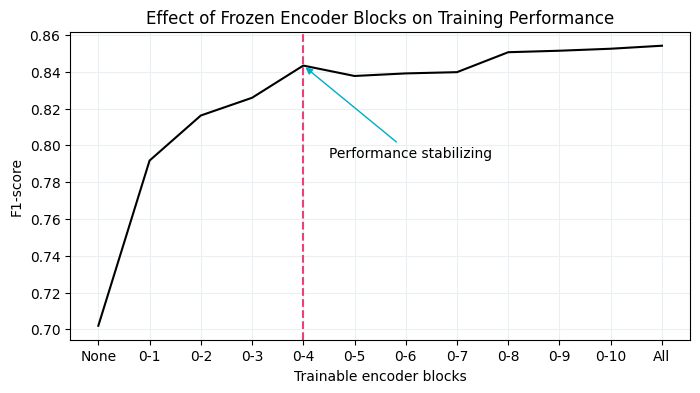

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 피겨 객체를 만듭니다.
plt.figure(figsize=(8,4))

# 데이터를 준비합니다.
x = [f"0-{index}" for index in range(12)]
x[0] = "None"
x[-1] = "All"
y = scores[::-1]

# 그래프 스타일 설정
plt.grid(color='#ECEFF1')
plt.axvline(x=4, color="#EC407A", linestyle="--")
plt.title("Effect of Frozen Encoder Blocks on Training Performance")
plt.ylabel("F1-score")
plt.xlabel("Trainable encoder blocks")

# 그래프를 그립니다.
plt.plot(x, y, color="black")

# 그래프 주석 추가
plt.annotate(
    'Performance stabilizing',
    xy=(4, y[4]),
    xytext=(4.5, y[4]-.05),
    arrowprops=dict(
        arrowstyle="-|>",
        connectionstyle="arc3",
        color="#00ACC1")
)
plt.savefig("multiple_frozen_blocks.png", dpi=300, bbox_inches='tight')

## 퓨-샷 분류

In [3]:
from setfit import sample_dataset

# 퓨-샷 설정을 흉내내기 위해 클래스마다 16개의 샘플을 선택합니다.
sampled_train_data = sample_dataset(tomatoes["train"], num_samples=16)

In [4]:
from setfit import SetFitModel

# 사전 훈련된 SentenceTransformer 모델을 로드합니다.
model = SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [5]:
from setfit import TrainingArguments as SetFitTrainingArguments
from setfit import Trainer as SetFitTrainer

# 훈련 매개변수를 정의합니다.
args = SetFitTrainingArguments(
    num_epochs=3,      # 대조 학습을 수행할 에포크 횟수
    num_iterations=20  # 생성할 텍스트 쌍 개수
)
args.eval_strategy = args.evaluation_strategy

# Trainer 객체를 만듭니다.
trainer = SetFitTrainer(
    model=model,
    args=args,
    train_dataset=sampled_train_data,
    eval_dataset=test_data,
    metric="f1"
)

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [6]:
# 훈련 루프
trainer.train()

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 3
/usr/local/lib/python3.11/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: roadhome (roadhome-wagak) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


In [7]:
# 테스트 데이터에서 모델을 평가합니다.
trainer.evaluate()

***** Running evaluation *****


{'f1': 0.845703125}

In [8]:
model.model_head

LogisticRegression()

## 마스크드 언어 모델링

In [7]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# 마스크드 언어 모델링을 위해 모델을 로드합니다.
model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

In [8]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

# 데이터를 토큰화합니다.
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns("label")
tokenized_test = test_data.map(preprocess_function, batched=True)
tokenized_test = tokenized_test.remove_columns("label")

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [9]:
from transformers import DataCollatorForLanguageModeling

# 토큰 마스킹
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [ ]:
# from transformers import DataCollatorForWholeWordMask

# # 전체 단어 마스킹
# data_collator = DataCollatorForWholeWordMask(
#     tokenizer=tokenizer,
#     mlm=True,
#     mlm_probability=0.15
# )

In [15]:
# 훈련 매개변수
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=10,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer 객체 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    processing_class=tokenizer,
    data_collator=data_collator
)

In [16]:
# 사전 훈련된 토크나이저를 저장합니다.
tokenizer.save_pretrained("mlm")

# 모델을 훈련합니다.
trainer.train()

# 업데이트된 모델을 저장합니다.
model.save_pretrained("mlm")

Step,Training Loss
500,2.604200
1000,2.371300


Step,Training Loss
500,2.604200
1000,2.371300
1500,2.306600
2000,2.190800
2500,2.149400
3000,2.089100
3500,2.053200
4000,1.993300
4500,1.986600
5000,1.955400


In [17]:
from transformers import pipeline

# 모델을 로드하고 예측을 만듭니다.
mask_filler = pipeline("fill-mask", model="bert-base-cased")
preds = mask_filler("What a horrible [MASK]!")

# 결과를 출력합니다.
for pred in preds:
    print(f">>> {pred['sequence']}")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


>>> What a horrible idea!
>>> What a horrible dream!
>>> What a horrible thing!
>>> What a horrible day!
>>> What a horrible thought!


In [18]:
# 모델을 로드하고 예측을 만듭니다.
mask_filler = pipeline("fill-mask", model="mlm")
preds = mask_filler("What a horrible [MASK]!")

# 결과를 출력합니다.
for pred in preds:
    print(f">>> {pred['sequence']}")

Device set to use cuda:0


>>> What a horrible movie!
>>> What a horrible film!
>>> What a horrible mess!
>>> What a horrible comedy!
>>> What a horrible story!


## 개체명 인식

개체명 인식에 관련된 흥미로운 데이터셋:
* tner/mit_movie_trivia
* tner/mit_restaurant
* wnut_17
* conll2003

In [11]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import numpy as np

In [19]:
# CoNLL-2003 데이터셋
dataset = load_dataset("conll2003", trust_remote_code=True)

In [20]:
example = dataset["train"][848]
example

{'id': '848',
 'tokens': ['Dean',
  'Palmer',
  'hit',
  'his',
  '30th',
  'homer',
  'for',
  'the',
  'Rangers',
  '.'],
 'pos_tags': [22, 22, 38, 29, 16, 21, 15, 12, 23, 7],
 'chunk_tags': [11, 12, 21, 11, 12, 12, 13, 11, 12, 0],
 'ner_tags': [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]}

In [21]:
label2id = {
    'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4,
    'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8
}
id2label = {index: label for label, index in label2id.items()}
label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

In [22]:
from transformers import AutoModelForTokenClassification

# 토크나이저를 로드합니다.
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# 모델을 로드합니다.
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# 개별 토큰을 부분 토큰으로 나눕니다.
token_ids = tokenizer(example["tokens"], is_split_into_words=True)["input_ids"]
sub_tokens = tokenizer.convert_ids_to_tokens(token_ids)
sub_tokens

['[CLS]',
 'Dean',
 'Palmer',
 'hit',
 'his',
 '30th',
 'home',
 '##r',
 'for',
 'the',
 'Rangers',
 '.',
 '[SEP]']

In [24]:
def align_labels(examples):
    token_ids = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = examples["ner_tags"]

    updated_labels = []
    for index, label in enumerate(labels):

        # 토큰을 해당 단어에 매핑합니다.
        word_ids = token_ids.word_ids(batch_index=index)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:

            # 새로운 단어의 시작
            if word_idx != previous_word_idx:

                previous_word_idx = word_idx
                updated_label = -100 if word_idx is None else label[word_idx]
                label_ids.append(updated_label)

            # 특수 토큰은 -100
            elif word_idx is None:
                label_ids.append(-100)

            # # 레이블이 B-XXX이면 I-XXX로 바꿉니다.
            else:
                updated_label = label[word_idx]
                if updated_label % 2 == 1:
                    updated_label += 1
                label_ids.append(updated_label)

        updated_labels.append(label_ids)

    token_ids["labels"] = updated_labels
    return token_ids

tokenized = dataset.map(align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [26]:
# 원본 레이블와 업데이트된 레이블
print(f"원본 레이블: {example['ner_tags']}")
print(f"업데이트된 레이블: {tokenized['train'][848]['labels']}")

원본 레이블: [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]
업데이트된 레이블: [-100, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, -100]


In [27]:
import evaluate

# seqeval을 로드합니다.
seqeval = evaluate.load("seqeval")

def compute_metrics(eval_pred):
    # 예측을 만듭니다.
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=2)

    true_predictions = []
    true_labels = []

    # 문서 수준 반복
    for prediction, label in zip(predictions, labels):

      # 토큰 수준 반복
      for token_prediction, token_label in zip(prediction, label):

        # 특수 토큰은 무시합니다.
        if token_label != -100:
          true_predictions.append([id2label[token_prediction]])
          true_labels.append([id2label[token_label]])

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {"f1": results["overall_f1"]}

In [28]:
from transformers import DataCollatorForTokenClassification

# 토큰 분류 DataCollator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [29]:
# 훈련 매개변수
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer 객체 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

<ipython-input-29-f0bef373ba7d>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.223800


TrainOutput(global_step=878, training_loss=0.16216078434555298, metrics={'train_runtime': 193.1355, 'train_samples_per_second': 72.7, 'train_steps_per_second': 4.546, 'total_flos': 351240792638148.0, 'train_loss': 0.16216078434555298, 'epoch': 1.0})

In [31]:
# 테스트 데이터에서 모델을 평가합니다.
trainer.evaluate()

{'eval_loss': 0.1440805196762085,
 'eval_f1': 0.9027192646495595,
 'eval_runtime': 10.9674,
 'eval_samples_per_second': 314.841,
 'eval_steps_per_second': 19.695,
 'epoch': 1.0}

In [30]:
from transformers import pipeline

# 미세 튜닝된 모델을 저장합니다.
trainer.save_model("ner_model")

# 미세 튜닝된 모델로 추론을 수행합니다.
token_classifier = pipeline(
    "token-classification",
    model="ner_model",
)
token_classifier("My name is Maarten.")

Device set to use cuda:0


[{'entity': 'B-PER',
  'score': 0.9826026,
  'index': 4,
  'word': 'Ma',
  'start': 11,
  'end': 13},
 {'entity': 'I-PER',
  'score': 0.867277,
  'index': 5,
  'word': '##arte',
  'start': 13,
  'end': 17},
 {'entity': 'I-PER',
  'score': 0.9119439,
  'index': 6,
  'word': '##n',
  'start': 17,
  'end': 18}]